In [1]:
import os
os.chdir("/content/drive/MyDrive")

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import models
from keras import utils

In [3]:
barcode = np.load("Preprocessed Data/barcode.npy")
tra = np.load("Preprocessed Data/tra.npy")
tra_embedding = np.load("Preprocessed Data/tra_embedding.npy")
trb = np.load("Preprocessed Data/trb.npy")
trb_embedding = np.load("Preprocessed Data/trb_embedding.npy")
rna = np.load("Preprocessed Data/rna.npy")
specificity = np.load("Preprocessed Data/specificity.npy")

max_length = 0
for chain in tra + trb:
  if len(chain) > max_length:
    max_length = len(chain)

In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_2 (Conv2D)              (None, 16, 16, 32)   320         ['input_2[0][0]']                
                                                                                            

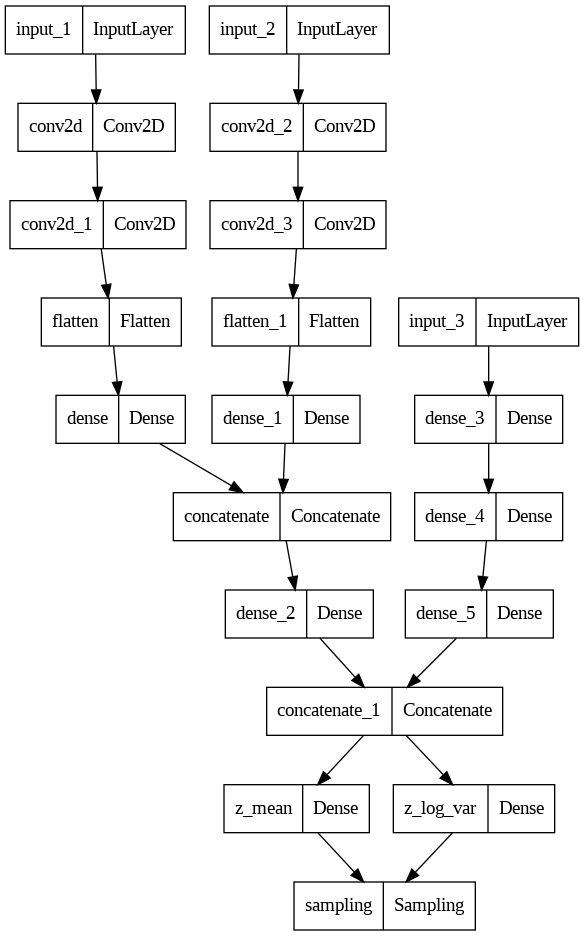

In [5]:
latent_dim = 2

tra_encoder_inputs = keras.Input(shape=(32, 32, 1))
tra_x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(tra_encoder_inputs)
tra_x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(tra_x)
tra_x = layers.Flatten()(tra_x)
tra_x = layers.Dense(32, activation="relu")(tra_x)

trb_encoder_inputs = keras.Input(shape=(32, 32, 1))
trb_x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(trb_encoder_inputs)
trb_x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(trb_x)
trb_x = layers.Flatten()(trb_x)
trb_x = layers.Dense(32, activation="relu")(trb_x)

tcr_x = layers.Concatenate()([tra_x, trb_x])
tcr_x = layers.Dense(32, activation = "relu")(tcr_x)

rna_encoder_inputs = keras.Input(shape=(1024))
rna_x = layers.Dense(128, activation = "relu")(rna_encoder_inputs)
rna_x = layers.Dense(64, activation = "relu")(rna_x)
rna_x = layers.Dense(32, activation = "relu")(rna_x)

x = layers.Concatenate()([tcr_x, rna_x])
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(inputs = [tra_encoder_inputs, trb_encoder_inputs, rna_encoder_inputs], outputs = [z_mean, z_log_var, z], name="encoder")

encoder.summary()
utils.plot_model(encoder)

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 64)           192         ['input_4[0][0]']                
                                                                                                  
 lambda_1 (Lambda)              ((None, 32),         0           ['dense_6[0][0]']                
                                 (None, 32))                                                      
                                                                                                  
 dense_8 (Dense)                (None, 4096)         135168      ['lambda_1[0][0]']         

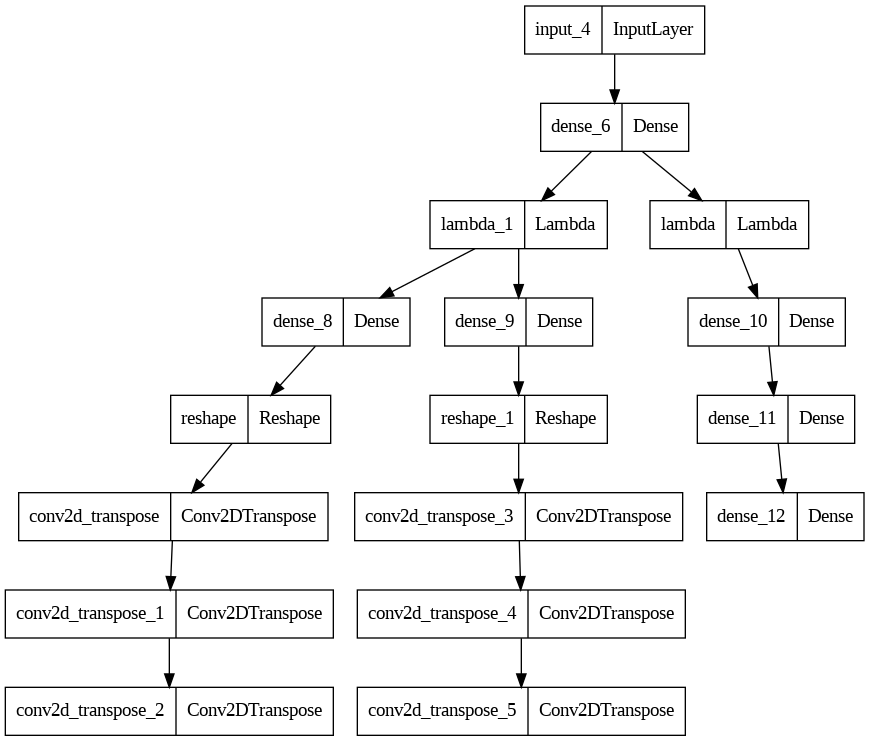

In [6]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(64, activation="relu")(latent_inputs)

def split_function(concatenated_tensor):
  half = int(concatenated_tensor.shape[1] / 2)
  split_1 = concatenated_tensor[:, : half]
  split_2 = concatenated_tensor[:, half : ]
  return split_1, split_2

tcr_x, rna_x = layers.Lambda(split_function)(x)

tcr_x = layers.Dense(64, activation = "relu")(tcr_x)
tra_x, trb_x = layers.Lambda(split_function)(x)
tra_x = layers.Dense(8 * 8 * 64)(tra_x)
trb_x = layers.Dense(8 * 8 * 64)(trb_x)

tra_x = layers.Reshape((8, 8, 64))(tra_x)
tra_x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(tra_x)
tra_x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(tra_x)
tra_decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(tra_x)

trb_x = layers.Reshape((8, 8, 64))(trb_x)
trb_x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(trb_x)
trb_x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(trb_x)
trb_decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(trb_x)

rna_x = layers.Dense(64, activation="relu")(rna_x)
rna_x = layers.Dense(128, activation="relu")(rna_x)
rna_decoder_outputs = layers.Dense(1024, activation="relu")(rna_x)

decoder = keras.Model(inputs = latent_inputs, outputs = [tra_decoder_outputs, trb_decoder_outputs, rna_decoder_outputs], name="decoder")

decoder.summary()
utils.plot_model(decoder)

In [ ]:
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super().__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    self.tra_reconstruction_loss_tracker = keras.metrics.Mean(
      name="tra_reconstruction_loss"
    )
    self.trb_reconstruction_loss_tracker = keras.metrics.Mean(
      name="trb_reconstruction_loss"
    )
    self.rna_reconstruction_loss_tracker = keras.metrics.Mean(
      name="rna_reconstruction_loss"
    )
    self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

  @property
  def metrics(self):
    return [
      self.total_loss_tracker,
      self.tra_reconstruction_loss_tracker,
      self.trb_reconstruction_loss_tracker,
      self.rna_reconstruction_loss_tracker,
      self.kl_loss_tracker,
    ]

  def train_step(self, data):
    tra, trb, rna = data[0]
    with tf.GradientTape() as tape:
      z_mean, z_log_var, z = self.encoder(data)
      reconstruction = self.decoder(z)
      tra_reconstructed, trb_reconstructed, rna_reconstructed = reconstruction
      tra_reconstruction_loss = tf.reduce_mean(
          tf.reduce_sum(
              keras.losses.binary_crossentropy(tra, tra_reconstructed), axis=(1, 2)
          )
      )
      trb_reconstruction_loss = tf.reduce_mean(
          tf.reduce_sum(
              keras.losses.binary_crossentropy(trb, trb_reconstructed), axis=(1, 2)
          )
      )
      rna_reconstruction_loss = tf.reduce_mean(
          tf.reduce_sum(
              keras.losses.binary_crossentropy(rna, rna_reconstructed)
          )
      )
      kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
      kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
      total_loss = tra_reconstruction_loss + trb_reconstruction_loss + 1 * rna_reconstruction_loss + kl_loss
    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.total_loss_tracker.update_state(total_loss)
    self.tra_reconstruction_loss_tracker.update_state(tra_reconstruction_loss)
    self.trb_reconstruction_loss_tracker.update_state(trb_reconstruction_loss)
    self.rna_reconstruction_loss_tracker.update_state(rna_reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    return {
      "loss": self.total_loss_tracker.result(),
      "tra_reconstruction_loss": self.tra_reconstruction_loss_tracker.result(),
      "trb_reconstruction_loss": self.trb_reconstruction_loss_tracker.result(),
      "rna_reconstruction_loss": self.rna_reconstruction_loss_tracker.result(),
      "kl_loss": self.kl_loss_tracker.result(),
    }

In [ ]:
import cv2

tra_embedding = list(tra_embedding)
for i in range(len(tra_embedding)):
  tra_embedding[i] = cv2.resize(tra_embedding[i], (32, 32))
tra_embedding = np.array(tra_embedding)

trb_embedding = list(trb_embedding)
for i in range(len(trb_embedding)):
  trb_embedding[i] = cv2.resize(trb_embedding[i], (32, 32))
trb_embedding = np.array(trb_embedding)

In [ ]:
# Min-max normalization
tra_min = min(tra_embedding.flatten())
tra_max = max(tra_embedding.flatten())
tra_embedding = (np.expand_dims(tra_embedding, -1) - tra_min) / (tra_max - tra_min)

trb_min = min(trb_embedding.flatten())
trb_max = max(trb_embedding.flatten())
trb_embedding = (np.expand_dims(trb_embedding, -1) - trb_min) / (trb_max - trb_min)

rna_min = min(rna.flatten())
rna_max = max(rna.flatten())
rna = (rna - rna_min) / (rna_max - rna_min)

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [ ]:
%%capture
history = vae.fit([tra_embedding, trb_embedding, rna], epochs=100, batch_size=1280)

In [ ]:
import matplotlib.pyplot as plt

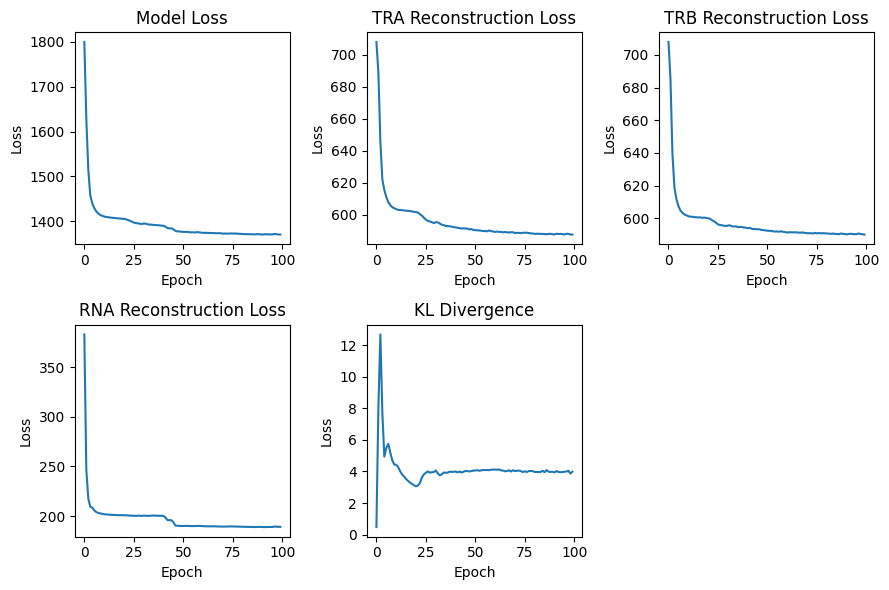

In [ ]:
plt.figure(figsize = (9, 6))
plt.subplot(2, 3, 1)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel("Epoch")
plt.ylabel('Loss')

plt.subplot(2, 3, 2)
plt.plot(history.history['tra_reconstruction_loss'])
plt.title('TRA Reconstruction Loss')
plt.xlabel("Epoch")
plt.ylabel('Loss')

plt.subplot(2, 3, 3)
plt.plot(history.history['trb_reconstruction_loss'])
plt.title('TRB Reconstruction Loss')
plt.xlabel("Epoch")
plt.ylabel('Loss')

plt.subplot(2, 3, 4)
plt.plot(history.history['rna_reconstruction_loss'])
plt.title('RNA Reconstruction Loss')
plt.xlabel("Epoch")
plt.ylabel('Loss')

plt.subplot(2, 3, 5)
plt.plot(history.history['kl_loss'])
plt.title('KL Divergence')
plt.xlabel("Epoch")
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

249/249 [==============================] - 1s 2ms/step


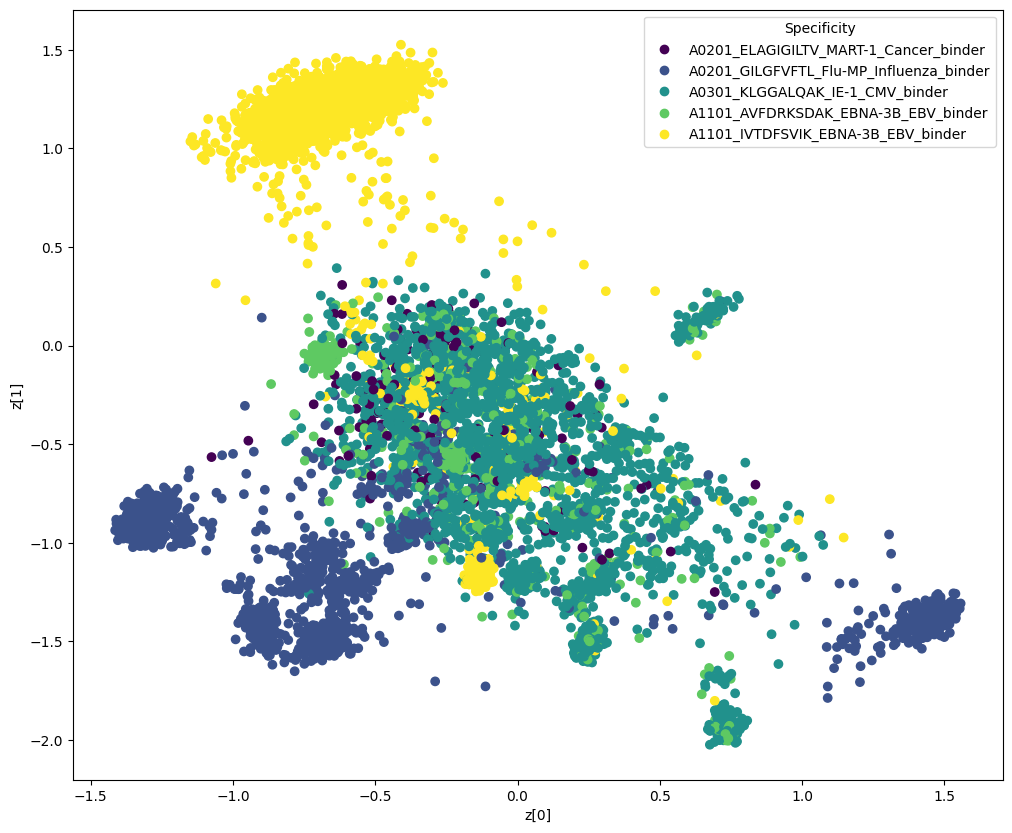

In [ ]:
x_train = [tra_embedding, trb_embedding, rna]
y_train = specificity

data = x_train
labels = y_train


unique_labels = []
numerized_labels = []
for label in labels:
  if label not in unique_labels:
    unique_labels.append(label)
unique_labels = sorted(unique_labels)
for label in labels:
  numerized_labels.append(unique_labels.index(label))
# display a 2D plot of the digit classes in the latent space
z_mean, _, _ = vae.encoder.predict(data)
plt.figure(figsize=(12, 10))
ax = plt.gca()
scatter = ax.scatter(z_mean[:, 0], z_mean[:, 1], c=numerized_labels)
legend = ax.legend(*scatter.legend_elements(), title='Specificity')
for i in range(len(unique_labels)):
    legend.get_texts()[i].set_text(unique_labels[i])
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()

np.save("TCR-RNA Data/z_mean.npy", z_mean)